Phase 4 Project - Kaggle Competition "Natural Language Processing with Disaster Tweets"

## Business Problem

Data has been accumulated from a number of tweets, some of which are about disasters, some of which are not. By creating a model for Natural Language Processing (NLP), we can predict whether or not a given tweet is about a real disaster or not. This can benefit companies who wish to monitor twitter in the event of an emergency.

## Data Understanding

Necessary imports:


In [80]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
import numpy as np 
import nltk
np.random.seed(42)
import seaborn as sns
import re
import pandas as pd 
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

### Data Exploration:

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
# Example of what is NOT a disaster tweet:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

In [7]:
# Example of what IS a disaster tweet:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

###### Visualizing what proportion of the training data are disaster tweets and non-disaster tweets

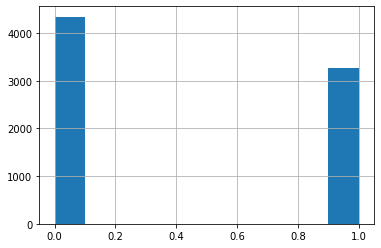

In [14]:
train_df['target'].hist();

## Data Preparation

In [26]:

from sklearn.model_selection import train_test_split 

X = train_df.text
y = train_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

#### Cleaning text data:
need to remove urls, tags (contain @), stopwords, punctuation, etc.

In [100]:
# Removing stopwords, punctuation, numbers, and bad characters 
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
import re

stopwords_list = stopwords.words('english')

no_bad_chars = re.compile('[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n - ]')
no_nums = re.compile('[\d-]')

def clean_text(text):
    text = text.lower() 
    #text = no_bad_chars.sub(' ', text) 
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    text = text.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    #text = ' '.join(word for word in text.split() if word not in stopwords_list)
    return text
    

X_train_cleaned = X_train.apply(clean_text)
X_test_cleaned = X_test.apply(clean_text)
X_train_cleaned.head(10) 

5151      this makes sense. paper beats rock paper com...
6351    ': the causes of federal failure are deeply st...
3443    well as i was chaning an ipad screen it fuckin...
7164    the war on drugs has turned the u.s. into a wa...
7037    obama declares disaster for typhoondevastated ...
5159    according to prophecy and also cnn a mac table...
1010    has body bagged ** rt  lac: drake is body bagg...
5070     askconnor if you were a natural disaster what...
2069     i need you to confirm that ross is dead cause...
931      he did get a  'bump' of approval which is pro...
Name: text, dtype: object

___________


### Laplace smoothing  (attempt)

In [15]:
disaster_tweets = train_df[train_df['target']==1]

other_tweets = train_df[train_df['target']==0]

###### Calculating the probabilities of disaster and non-disaster tweets in the training data:

In [27]:
P_disasters = len(disaster_tweets) /(len(disaster_tweets)+len(other_tweets))
P_non = len(other_tweets) /(len(other_tweets)+len(disaster_tweets))
print(P_disasters)
print(P_non)

0.4296597924602653
0.5703402075397347


In [28]:
# need set of unique tokens

In [29]:
bigrams = (tuple(nltk.bigrams(X_train,pad_left=True, pad_right=True)))

In [30]:
bigr = nltk.bigrams(X_train,pad_left=True, pad_right=True)

In [31]:
frequencyDist = nltk.ConditionalFreqDist(bigr)
frequencyDist

<ConditionalFreqDist with 5650 conditions>

In [32]:
# laplace smoothing = used to correct probabilities of words so there are no zeroes
#categories will be 1 and 0
def vocab_maker(category):
    vocab_category = set()
    
    for tweet in category:
        words = tweet.split()
        for word in words:
            vocab_category.add(word)
    return vocab_category

In [33]:
voc_dis = vocab_maker(disaster_tweets['text'])
voc_non = vocab_maker(other_tweets['text'])

In [34]:
voc_all = voc_dis.union(voc_non)
voc_all

{'21',
 'Ns',
 'primarily...',
 '@traplord_29',
 'http://t.co/Ch6E7vTATR',
 'http://t.co/ct2JUtvYTg',
 'CHONCE',
 '#AdiosSuperBacterias',
 'Force...',
 'ET',
 'veteran',
 'INFO',
 'trickshot',
 'http://t.co/2o7Eva1cOe',
 'blight...',
 "Night'",
 '#spain',
 'Shadowflame',
 '($)',
 'Half',
 'Ending',
 'proper',
 'DROID',
 'ETO',
 '5.139055',
 'http://t.co/mFSw0tYstA',
 'efforts',
 'You)',
 'seatbelt!!!...',
 'http://t.co/itZzKWfhG5',
 'paulista',
 'DOWN',
 'Wed...',
 'http://t.co/R33nCvjovC',
 '(415)',
 'http://t.co/vVE3UsesGf',
 'body-bagging',
 '#US?',
 'occupants',
 '4:30',
 'hostage!',
 '#iJETalerts',
 'interactions.',
 'scum',
 'y',
 'harbor',
 'roller.',
 'burned:',
 'RT?',
 'standard',
 'http://t.co/1RrEO2jG9u',
 '@accionempresa',
 'http://t.co/3bwWNLsxhB',
 "bomb'",
 '#CNN',
 '@LindaSOCVAT',
 'knew.',
 'time)',
 'http://t.co/5FcJVMl520',
 'SlideShare',
 '1976.',
 '2.4RegionåÊåÊNEAR',
 'remixes.',
 'http://t.co/7IEiZ619h0',
 'http://t.co/2kdq56xTWs',
 '(Black)',
 'Nearly',
 'Overl

In [35]:
from nltk import *

train_df['text'].vocab()

AttributeError: 'Series' object has no attribute 'vocab'

In [42]:
total_vocab_count = len(voc_all)
total_dis_count = len(voc_dis)
total_non_count = len(voc_non)

In [43]:
print(total_vocab_count, total_dis_count, total_non_count)

31924 16150 20560


In [44]:
frequencyDist = nltk.ConditionalFreqDist()

In [45]:
probabilityDist = nltk.ConditionalProbDist(frequencyDist, nltk.LaplaceProbDist, bins=frequencyDist.N())
probabilityDist

<ConditionalProbDist with 0 conditions>

In [46]:
#Clean keywords for better idea of trends
def clean_keywords(keyword):
    cleaned = re.sub(r'%20', ' ', keyword)
    return cleaned
def remove_accents(keyword):
    cleaned = unidecode.unidecode(keyword)
    return cleaned
def remove_punctuation(keyword):
    cleaned = re.sub(r"[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n -' ]"," ",keyword)
    return cleaned
#train_df['keyword'].apply(clean_keywords)

_______

In [51]:
#tokenize the cleaned tweets data:
from nltk.tokenize import word_tokenize
word_tokens = word_tokenize(word)
tokenized_sample_tweet = word_tokenize(train_sample)
tokenized_sample_tweet

NameError: name 'word' is not defined

In [53]:
# Tokenizing the data:
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = r"(?u)\b\w\w+\b"

regex_tokenizer = RegexpTokenizer(basic_token_pattern)

X_train_tokenized = X_train_cleaned.copy()
X_test_tokenized = X_test_cleaned.copy()
X_train_tokenized = X_train_cleaned.apply(tokenizer.tokenize)
X_test_tokenized = X_test_cleaned.apply(tokenizer.tokenize)


In [37]:
X_train_tokenized

5151    [makes, sense, paper, beats, rock, paper, come...
6351    [causes, federal, failure, deeply, structural,...
3443    [well, chaning, ipad, screen, fucking, explode...
7164                      [war, drugs, turned, war, zone]
7037    [obama, declares, disaster, typhoondevastated,...
                              ...                        
5226    [many, obliteration, servers, always, like, play]
5390    [panic, attack, bc, enough, money, drugs, alco...
860     [omron, hemc, automatic, blood, pressure, moni...
7603    [officials, say, quarantine, place, alabama, h...
7270    [moved, england, five, years, ago, today, whir...
Name: text, Length: 5709, dtype: object

In [39]:
# Keep this cell??
from nltk import FreqDist

train_df["text_tokenized"] = train_df["text"].apply(tokenizer.tokenize)
test_df["text_tokenized"] = test_df["text"].apply(tokenizer.tokenize)

train_df["text_tokenized"].explode()
test_df["text_tokenized"].explode()

0            Just
0        happened
0        terrible
0             car
0           crash
          ...    
3262          its
3262    Municipal
3262    Emergency
3262         Plan
3262     yycstorm
Name: text_tokenized, Length: 50940, dtype: object

In [53]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
#visualize_top_10(example_freq_dist, "Top 10 Word Frequency for Example Tokens")


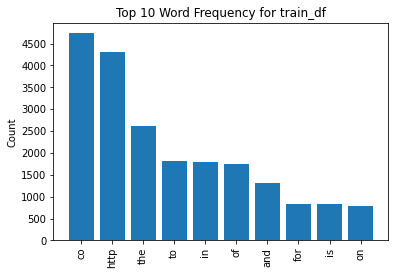

In [54]:
train_freq_dist = FreqDist(train_df["text_tokenized"].explode())
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for train_df")

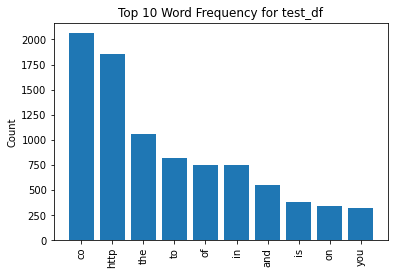

In [55]:
test_freq_dist = FreqDist(test_df["text_tokenized"].explode())
visualize_top_10(test_freq_dist, "Top 10 Word Frequency for test_df")

In [56]:
# Is this cell necessary?

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10)
#max_features=None
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

# Which do I use?? The whole train_df or just X_train?

train_df_vectorized = tfidf.fit_transform(train_df)
test_df_vectorized = tfidf.transform(test_df)

pd.DataFrame.sparse.from_spmatrix(train_df_vectorized, columns=tfidf.get_feature_names())

,id,keyword,location,target,text,text_tokenized
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0


In [57]:
X_train_tokenized

5151    [dicehateme, PuppyShogun, This, makes, sense, ...
6351    [CatoInstitute, The, causes, of, federal, fail...
3443    [Well, as, was, chaning, an, iPad, screen, it,...
7164    [the, war, on, drugs, has, turned, the, into, ...
7037    [Obama, Declares, Disaster, for, Typhoon, Deva...
                              ...                        
5226    [Eganator2000, There, aren, many, Obliteration...
5390    [just, had, panic, attack, bc, don, have, enou...
860     [Omron, HEM, 712C, Automatic, Blood, Pressure,...
7603    [Officials, say, quarantine, is, in, place, at...
7270    [moved, to, England, five, years, ago, today, ...
Name: text, Length: 5709, dtype: object

In [58]:
X_train_tokenized.iloc[70][:20]

['Madhya',
 'Pradesh',
 'Train',
 'Derailment',
 'Village',
 'Youth',
 'Saved',
 'Many',
 'Lives']

###### Word Vectorization

In [40]:
# Remove this section? text is vectorized in pipeline during modeling...

In [59]:
# first try count vectorization, then tf-idf ?
# Creating a 'bag of words'
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer(max_features=10)


In [60]:
X_train_count_vectorized = count_vec.fit_transform(X_train)
X_test_count_vectorized = count_vec.transform(X_test)

pd.DataFrame.sparse.from_spmatrix(X_train_count_vectorized, columns=count_vec.get_feature_names())

,and,co,for,http,in,is,of,the,to,you
0,1,0,0,0,0,0,0,0,1,0
1,1,1,0,1,0,0,1,1,0,0
2,1,0,0,0,0,1,0,1,1,0
3,0,0,0,0,0,0,0,2,0,0
4,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
5704,0,0,0,0,0,0,0,0,1,0
5705,1,0,1,0,0,0,0,1,1,0
5706,1,2,0,2,0,0,0,0,0,0
5707,0,1,0,1,1,1,0,0,0,0


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10, tokenizer=word_tokenize)


X_train_vectorized1 = tfidf.fit_transform(X_train)

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized1, columns=tfidf.get_feature_names())

,#,.,:,?,@,a,http,in,the,to
0,0.0,0.660024,0.000000,0.0,0.660956,0.000000,0.000000,0.000000,0.000000,0.357079
1,0.0,0.000000,0.792802,0.0,0.391163,0.000000,0.294835,0.000000,0.362669,0.000000
2,0.0,0.746706,0.000000,0.0,0.000000,0.398839,0.000000,0.000000,0.346645,0.403974
3,0.0,0.422978,0.000000,0.0,0.000000,0.451852,0.000000,0.000000,0.785442,0.000000
4,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
5704,0.0,0.000000,0.417074,0.0,0.617344,0.000000,0.000000,0.000000,0.000000,0.667035
5705,0.0,0.000000,0.000000,0.0,0.000000,0.599619,0.000000,0.000000,0.521150,0.607338
5706,0.0,0.000000,0.667451,0.0,0.000000,0.000000,0.744654,0.000000,0.000000,0.000000
5707,0.0,0.000000,0.261405,0.0,0.000000,0.825513,0.291642,0.406374,0.000000,0.000000


###### Building a baseline model

In [103]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

baseline_model = Pipeline([('vect', CountVectorizer(tokenizer=word_tokenize,
                                                   stop_words=stopwords_list)),
                           ('clf', MultinomialNB())
              ])
baseline_model.fit(X_train_cleaned, y_train)


from sklearn.metrics import classification_report
y_pred = baseline_model.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


F1 0.7556707712248865
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1091
           1       0.80      0.72      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904



In [104]:
# model with TF-IDF Vectorizer instead of CountVectorizer, added tfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
model2 = Pipeline([('vect', TfidfVectorizer(tokenizer=word_tokenize,
                                           stop_words=stopwords_list)),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB()),
                  ])
model2.fit(X_train_cleaned, y_train)


from sklearn.metrics import classification_report
y_pred2 = model2.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred2, y_test))
print(classification_report(y_test, y_pred2))

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


F1 0.7318087318087317
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1091
           1       0.84      0.65      0.73       813

    accuracy                           0.80      1904
   macro avg       0.81      0.78      0.78      1904
weighted avg       0.80      0.80      0.79      1904



In [105]:
# creating custom tokens
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [106]:
stem_model = Pipeline([('vect', TfidfVectorizer(
                         stop_words=stemmed_stopwords,
                         tokenizer=stem_and_tokenize)),
               ('clf', MultinomialNB()),
              ])
stem_model.fit(X_train_cleaned, y_train)


from sklearn.metrics import classification_report
y_pred_stem= stem_model.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred_stem, y_test))
print(classification_report(y_test, y_pred_stem))

F1 0.7500000000000001
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1091
           1       0.83      0.68      0.75       813

    accuracy                           0.81      1904
   macro avg       0.81      0.79      0.80      1904
weighted avg       0.81      0.81      0.80      1904



In [109]:
#What about lemmatization?
#nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer() 

def lem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [lemmatizer.lemmatize(token) for token in tokens]


lemm_stopwords = [lemmatizer.lemmatize(word) for word in stopwords_list]

In [110]:
lemm_model = Pipeline([('vect', TfidfVectorizer(
                         stop_words=lemm_stopwords,
                         tokenizer=lem_and_tokenize)),
                       ('clf', MultinomialNB()),
              ])
lemm_model.fit(X_train_cleaned, y_train)


from sklearn.metrics import classification_report
y_lemm_pred= lemm_model.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_lemm_pred, y_test))
print(classification_report(y_test, y_lemm_pred))

F1 0.7415426251691475
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1091
           1       0.82      0.67      0.74       813

    accuracy                           0.80      1904
   macro avg       0.81      0.78      0.79      1904
weighted avg       0.80      0.80      0.80      1904



______

Attempting GridSearch:

In [88]:
params = {
    "max_features": [None ,10, 100, 200],
}

In [64]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(tfidf , params, cv=3, return_train_score=True)

grid_search.fit(X_train, y_train, score='f1' )

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator TfidfVectorizer(max_features=10,
                tokenizer=<function word_tokenize at 0x7fe75eab99d0>) does not.

In [ ]:
# GridSearch??
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB() )
])

# Apparently the only hyperparams for MultinomialNB, but what do they mean?
# What about max_features?
parameters = {
    'alpha': (1, 2, 3),
    'class_prior': (),
    'fit_prior': ()
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'tfidf__use_idf': (True, False),
    #'reg__alpha': (0.00001, 0.000001),
    #"max_features": [None ,10, 100, 200],
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=1, verbose=1)

In [275]:
MultinomialNB().get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [273]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: Invalid parameter max_features for estimator Pipeline(steps=[('vect', TfidfVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())]). Check the list of available parameters with `estimator.get_params().keys()`.

In [62]:
# Removing stopwords, punctuation, numbers, and bad characters 
#nltk.download('stopwords', quiet=True)
#from nltk.corpus import stopwords
#import re

#stopwords_list = stopwords.words('english')

#no_bad_chars = re.compile('[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n - ]')
#no_nums = re.compile('[\d-]')

#def clean_text(text):
 #   text = text.lower() 
 #   text = no_bad_chars.sub(' ', text) 
 #   text = no_nums.sub('', text) 
 #   
 #   text = ' '.join(word for word in text.split() if word not in stopwords_list)
 #   return text
    

#X_train_cleaned = X_train.apply(clean_text)
#X_test_cleaned = X_test.apply(clean_text)
#X_train_cleaned.head(10) 

In [63]:
# see vocab for cleaned data
train_df_cleaned = train_df['text'].apply(clean_text)

disasters_cleaned = train_df_cleaned[train_df_cleaned['target']==1]
non_disasters_cleaned = train_df_cleaned[train_df_cleaned['target']==0]

voc_dis_cleaned = vocab_maker(disasters_cleaned['text'])
voc_non_cleaned = vocab_maker(non_disasters_cleaned['text'])

voc_all_cleaned = voc_dis_cleaned.union(voc_non_cleaned)
voc_all_cleaned

total_vocab_count_cl = len(voc_all_cleaned)
total_dis_count_cl = len(voc_dis_cleaned)
total_non_count_cl = len(voc_non_cleaned)

print(total_vocab_count_cl, total_dis_count_cl, total_non_count_cl)

KeyError: 'target'

In [67]:
#from sklearn.preprocessing import MultiLabelBinarizer
#model4 = Pipeline([('vect', MultiLabelBinarizer()),
               #('clf', MultinomialNB()),
              #])
#model4.fit(X_train, y_train)


#from sklearn.metrics import classification_report
#y_pred4 = model4.predict(X_test)

#print('accuracy %s' % accuracy_score(y_pred4, y_test))
#print(classification_report(y_test, y_pred4))



In [ ]:
# even worse than stemming...


In [262]:
#count_vectorizer = feature_extraction.text.CountVectorizer()
train_vectors = model2.fit_transform(train_df["text"])
test_vectors = model2.fit(train_vectors, train_df["target"])

ValueError: This MultinomialNB estimator requires y to be passed, but the target y is None.

In [ ]:
incr_features_cv = cross_val_score(clf, X_train_vectorized4, train_df["target"], cv=3, scoring="f1")
incr_features_cv.mean()

## Generating Predictions

After building baseline model, try things to improve score

In [237]:
sample_submission = pd.read_csv("data/sample_submission.csv")

In [261]:
sample_submission["target"] = model2.predict(test_vectors)

AttributeError: lower not found

In [102]:
train_df_vectorized = tfidf.fit_transform(train_df)
test_df_vectorized = tfidf.transform(test_df)

In [105]:
#best model:
final = Pipeline([('vect', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
final.fit(train_df_vectorized, y)


#from sklearn.metrics import classification_report
#y_pred = final.predict(test_df)

#print('accuracy %s' % accuracy_score(y_pred, y_test))
#print(classification_report(y_test, y_pred))



#clf.fit(train_vectors, train_df["target"])

AttributeError: lower not found

In [ ]:
clf.fit(train_vectors, train_df["target"])

## Evaluation

(evaluate using f1 metric)

## Conclusion